In [13]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys

In [1]:
from opt_einsum import contract


In [5]:
%load_ext line_profiler

In [14]:
L_list=np.arange(8,18,2)
# L_list=np.arange(10,14,2)

In [15]:
# dirpath='Data/Bitstring'
# dirpath='/home/jake/Data/Bitstring'
dirpath='.'

In [16]:
f_0={}
for L in L_list:
    f_0[L]=h5py.File(os.path.join(dirpath,f'CT_En2000_pctrl(0.00,1.00,21)_pproj(0.00,0.00,1)_L({L},{L+2},2)_xj(0)_seed0_64_wf.hdf5'))

In [17]:
def l1_coherence(rho,k,normalization=False,average=False):
    L=len(rho.shape)//2
    if k == 0:
        ket_idx=(0,)*L
    else:
        ket_idx=(0,)*(L-k)+(1,)+(slice(None),)*(k-1)

    bra_idx=(0,)*(L-k-1)+(1,)+(slice(None),)*(k)
    tr=trace(rho[ket_idx+ket_idx])+trace(rho[bra_idx+bra_idx])

    coh=np.abs(rho[ket_idx+bra_idx]).sum()

    if normalization:
        coh/=tr.real
    if average:
        coh/=np.prod(rho[ket_idx+bra_idx].shape)
    return coh

In [18]:
def l1_coherence_2(rho,k1,k2):
    L=len(rho.shape)//2
    if k1 == 0:
        ket_idx=(0,)*L
    else:
        ket_idx=(0,)*(L-k1)+(1,)+(slice(None),)*(k1-1)
    if k2 == 0:
        bra_idx=(0,)*L
    else:
        bra_idx=(0,)*(L-k2)+(1,)+(slice(None),)*(k2-1)
    if k1 == k2:
        return trace(rho[ket_idx+bra_idx])
    else:
        return np.abs(rho[ket_idx+bra_idx]).sum()

In [19]:
def trace(rho):
    L=len(rho.shape)
    if L>0:
        return np.einsum(rho,list(range(L//2))*2)
    else:
        return rho

In [20]:
def plot_coherence(rho,diag=False,ax=None,idx=(0,12)):
    if ax is None:
        fig,ax=plt.subplots()
    L=len(rho.shape)//2
    rho_abs=np.abs(rho).reshape((2**L,2**L))
    if diag:
        im=ax.imshow(rho_abs[idx[0]:idx[1],idx[0]:idx[1]])
    else:
        im=ax.imshow(rho_abs[idx[0]:idx[1],idx[0]:idx[1]]- np.diag(np.diag(rho_abs[idx[0]:idx[1],idx[0]:idx[1]])))
    axins=ax.inset_axes([1.05,0,0.05,1],transform=ax.transAxes)
    im=plt.colorbar(im,cax=axins,label=r'$|{\rho}|$')
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')


In [21]:
def get_rho_av(f_0,L,i):
    wf=f_0[L][f'wf_{L}'][i,0,0,...,:,0]
    # rho_av=np.abs(np.einsum(wf,np.r_[np.arange(0,L),2*L],np.conj(wf),np.r_[np.arange(L,2*L),2*L],np.arange(2*L))/f_0[L][f'wf_{L}'].shape[-2])
    rho_av=np.abs(contract(wf,np.r_[np.arange(0,L),2*L],np.conj(wf),np.r_[np.arange(L,2*L),2*L],np.arange(2*L))/f_0[L][f'wf_{L}'].shape[-2])
    return rho_av

In [22]:
def get_reduced_dm(rho):
    L=len(rho.shape)//2
    red_dm=np.zeros((L+1,L+1))
    for i in range(L+1):
        for j in range(i,L+1):
            red_dm[i,j]=l1_coherence_2(rho,i,j)
            red_dm[j,i]=red_dm[i,j]
    return red_dm



In [23]:
def get_reduce_dm_per_state(rho):
    L=rho.shape[0]-1
    # number_state=np.zeros((L+1,L+1))
    number_state=(np.r_[1,2**np.arange(L)])
    number_state_map=np.outer(number_state,number_state)
    np.fill_diagonal(number_state_map,number_state)
    
    return rho/number_state_map

In [24]:
def plot_reduced_dm(rho,ax=None):
    if ax is None:
        fig,ax=plt.subplots()
    im=ax.imshow(np.log10(rho+1e-6),cmap='Blues')
    axins=ax.inset_axes([1.05,0,0.05,1],transform=ax.transAxes)
    im=plt.colorbar(im,cax=axins,label=r'$|{\rho}|$')
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.set_xlabel('FDW')
    ax.set_ylabel('FDW')


In [111]:
del rho_av

In [119]:
def save_reduced_dm(f_0, L,idx_max=21):
    red_dm_list=np.zeros((idx_max,L+1,L+1),dtype=np.float64)
    red_dm_per_list=np.zeros((idx_max,L+1,L+1),dtype=np.float64)
    for idx in tqdm(range(idx_max)):
        rho_av=get_rho_av(f_0,L,idx)
        red_dm=get_reduced_dm(rho_av)
        red_dm_list[idx]=(red_dm)
        red_dm_per_list[idx]=(get_reduce_dm_per_state(red_dm))
    with h5py.File(f'rho_av_{L}.hdf5','w') as f:
        f.create_dataset('red_dm',data=red_dm_list)
        f.create_dataset('red_dm_per',data=red_dm_per_list)


In [120]:
save_reduced_dm(f_0,L=8)

100%|██████████| 21/21 [00:08<00:00,  2.50it/s]


In [125]:
save_reduced_dm(f_0,L=10)

 29%|██▊       | 6/21 [00:10<00:27,  1.86s/it]

In [ ]:
save_reduced_dm(f_0,L=12)

In [123]:
rho_av={}
for L in L_list:
    if os.path.exists(f'rho_av_{L}.hdf5'):
        rho_av[L]=h5py.File(f'rho_av_{L}.hdf5','r')

In [124]:
rho_av[8].keys()

<KeysViewHDF5 ['red_dm', 'red_dm_per']>

In [107]:
dm_0[8].shape

(21, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)

In [ ]:
rho_av={L:get_rho_av(f_0,L,5) for L in [8,10,12,14]}

In [84]:
rho_av={L:get_rho_av(f_0,L,5) for L in [8,10,12,14]}

In [100]:
# rho_av=get_rho_av(f_0,8,10)

In [86]:
# red_dm=get_reduced_dm(rho_av)
red_dm={L:get_reduced_dm(rho_av[L]) for L in [8,10,12,14]}

In [87]:
# red_dm_per=get_reduce_dm_per_state(red_dm)
red_dm_per={L:get_reduce_dm_per_state(red_dm[L]) for L in [8,10,12,14]}

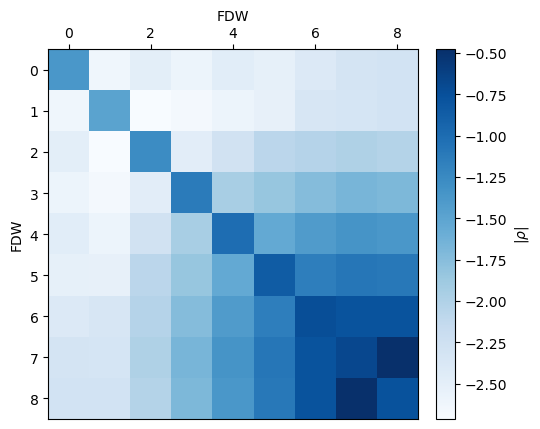

In [58]:
plot_reduced_dm(red_dm[8])

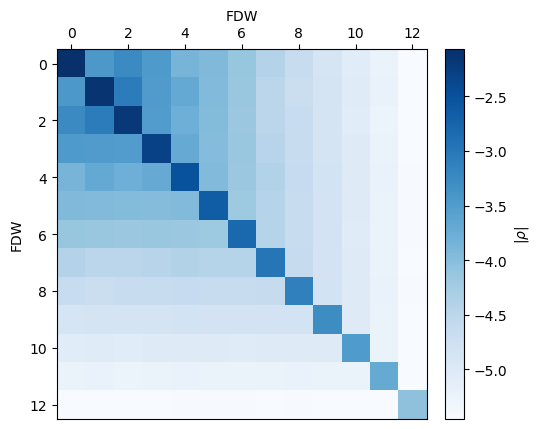

In [66]:
plot_reduced_dm(red_dm_per[12])

/tmp/ipykernel_4182577/1813485167.py:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(red_dm_per[L][0,1:],'.-',label=f'L={L}',ls='dashed')


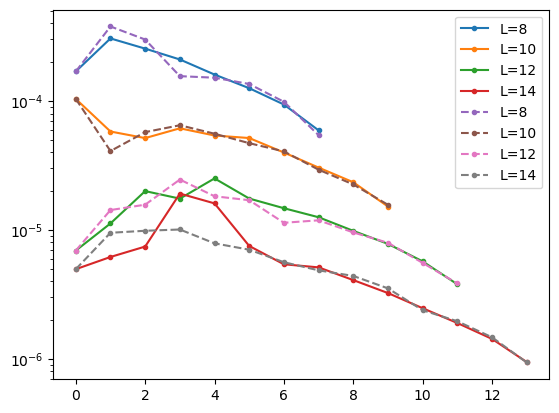

In [88]:
for L in [8,10,12,14]:
    plt.plot([red_dm_per[L][i,i+1] for i in range(L)],'.-',label=f'L={L}')
for L in [8,10,12,14]:
    plt.plot(red_dm_per[L][0,1:],'.-',label=f'L={L}',ls='dashed')
plt.legend()
plt.yscale('log')   
# plt.xscale('log')   

/tmp/ipykernel_4182577/1033578318.py:2: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(red_dm_per[L][4,:4],'.-',label=f'L={L}',ls='dashed')


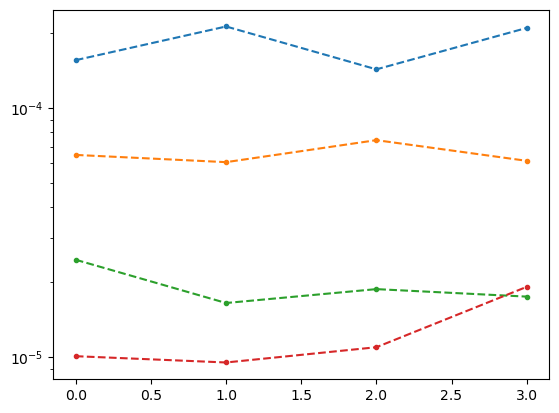

In [92]:
for L in [8,10,12,14]:
    plt.plot(red_dm_per[L][4,:4],'.-',label=f'L={L}',ls='dashed')
plt.yscale('log')

/tmp/ipykernel_4182577/2565562905.py:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(red_dm_per[L][0,1:],'.-',label=f'L={L}',ls='dashed')


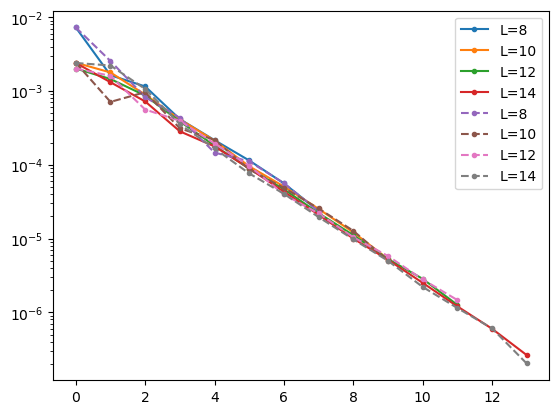

In [80]:
for L in [8,10,12,14]:
    plt.plot([red_dm_per[L][i,i+1] for i in range(L)],'.-',label=f'L={L}')
for L in [8,10,12,14]:
    plt.plot(red_dm_per[L][0,1:],'.-',label=f'L={L}',ls='dashed')
# plt.plot(red_dm_per[0,1:],'.-')
plt.legend()
plt.yscale('log')   
# plt.xscale('log')   

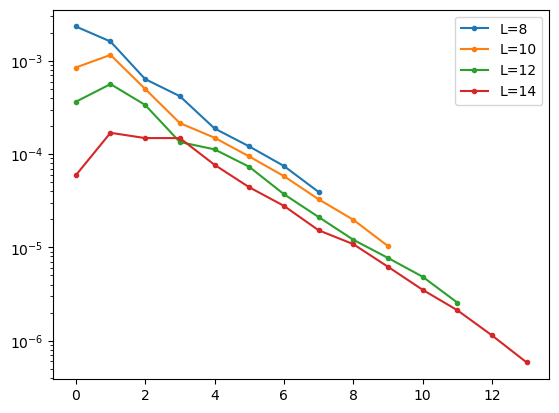

In [60]:
for L in [8,10,12,14]:
    plt.plot(red_dm_per[L][0,1:],'.-',label=f'L={L}')
# plt.plot(red_dm_per[0,1:],'.-')
plt.yscale('log')
plt.legend()

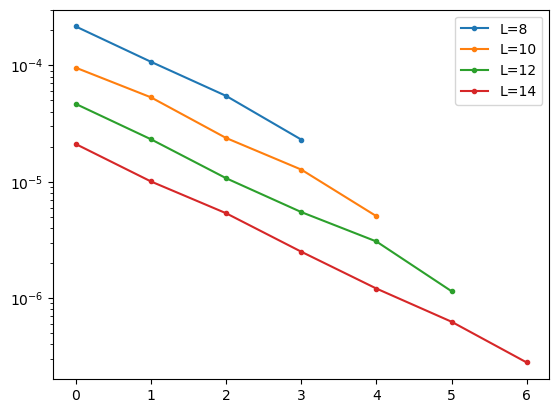

In [36]:
for L in [8,10,12,14]:
    plt.plot(red_dm_per[L][L//2,L//2+1:],'.-',label=f'L={L}')
# plt.plot(red_dm_per[0,1:],'.-')
plt.yscale('log')
plt.legend()

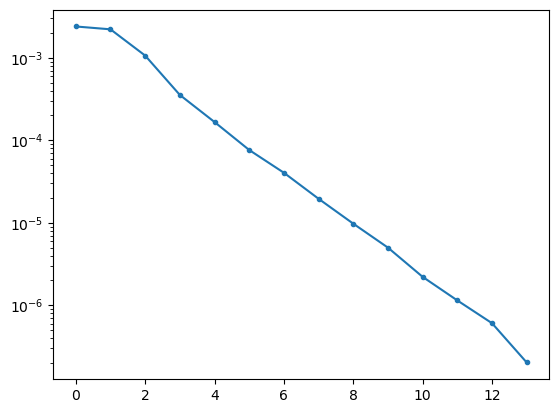

In [306]:
plt.plot(red_dm_per[0,1:],'.-')
plt.yscale('log')

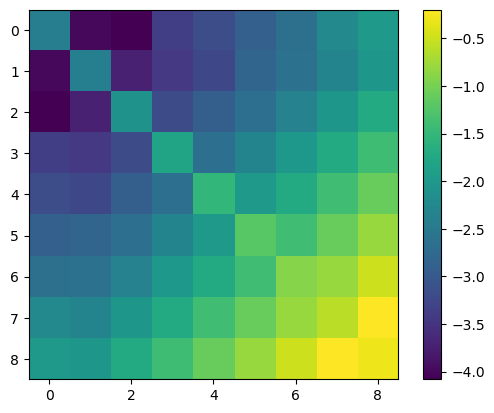

In [93]:
plt.imshow(np.log10(red_dm))
plt.colorbar()

In [ ]:
plt.imshow(np.log10(red_dm_per))
plt.colorbar()

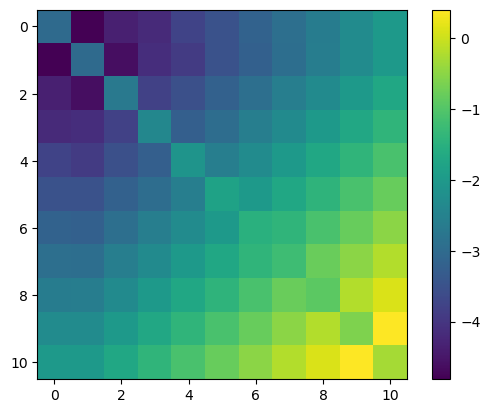

In [ ]:
plt.imshow(np.log10(red_dm))
plt.colorbar()

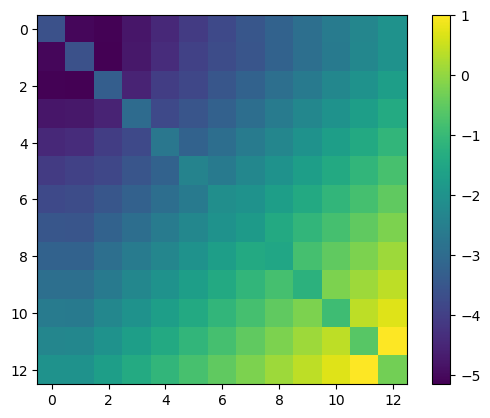

In [57]:
plt.imshow(np.log10(red_dm))
plt.colorbar()

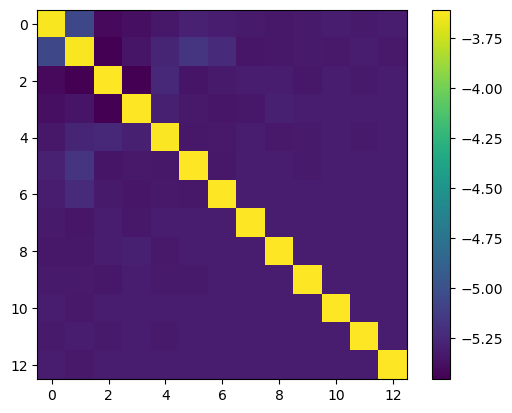

In [82]:
plt.imshow(np.log10(red_dm_per))
plt.colorbar()

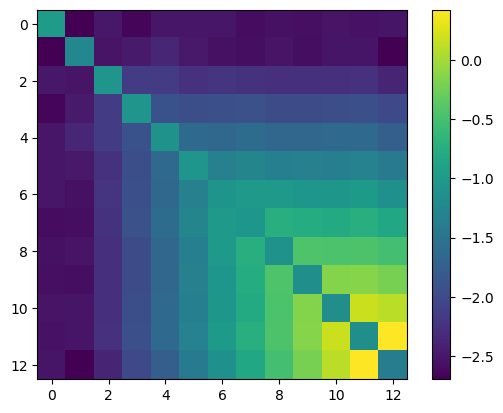

In [86]:
plt.imshow(np.log10(red_dm))
plt.colorbar()

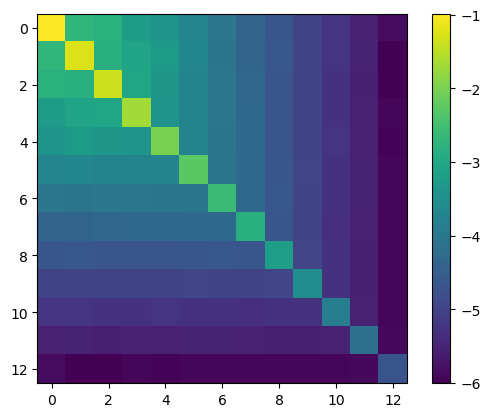

In [87]:
plt.imshow(np.log10(red_dm_per))
plt.colorbar()

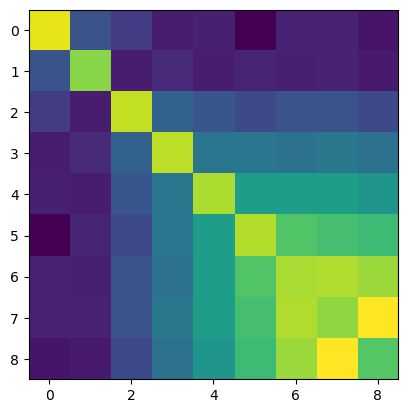

In [40]:
plt.imshow(np.log10(red_dm))

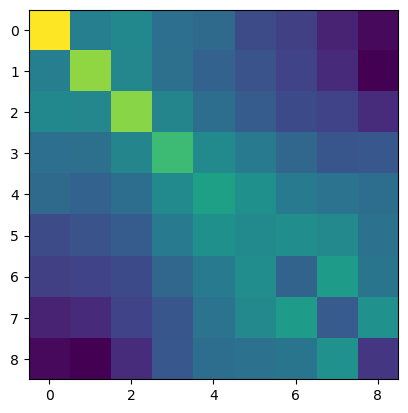

In [44]:
plt.imshow(np.log10(red_dm))

In [22]:
l1_coherence_2(rho_av,0,1)

0.00010143755762719205

In [13]:
l1_coherence_2(rho_av,1,1)

0.003915372962018893

In [14]:
l1_coherence_2(rho_av,0,1,)

0.00010143755762719205

In [15]:
rho_av.reshape((2**1,2**1))[:4,:4]

ValueError: cannot reshape array of size 65536 into shape (4096,4096)

In [14]:
sys.getsizeof(rho_av)/2**10/2**10

128.00045776367188

In [16]:
l1_coherence_2(rho_av,0,0)

0.0038090870155051016

In [17]:
l1_coherence_2(rho_av,1,1)

0.003915372962018893

In [18]:
l1_coherence_2(rho_av,0,1)

0.00010143755762719205

In [19]:
l1_coherence_2(rho_av,1,2)

0.00018960059500231185

In [18]:
(2**14)**2*8/2**20

2048.0

In [20]:
(2**16)**2*8/2**30

32.0

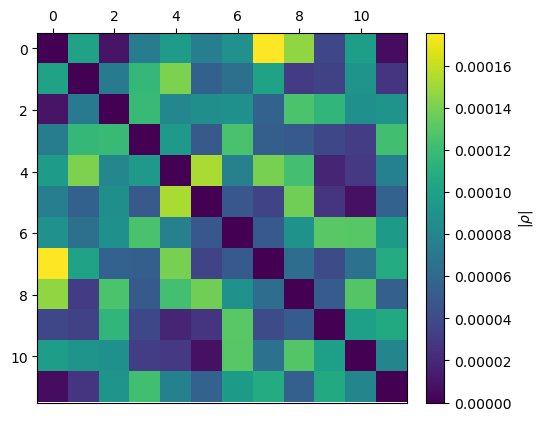

In [14]:
plot_coherence(rho_av,diag=False)

In [15]:
def l1_coherence_all(f_0,L,i,normalization=False,average=True):
    # wf=f_0[L][f'wf_{L}'][i,0,0,...,:,0]
    # dm_av=np.einsum(wf,np.r_[np.arange(0,L),2*L],np.conj(wf),np.r_[np.arange(L,2*L),2*L],np.arange(2*L))/f_0[L][f'wf_{L}'].shape[-2]

    rho_av=get_rho_av(f_0,L,i)
    
    return [l1_coherence(rho_av,k,normalization=normalization,average=average) for k in range(L)]

In [54]:
l1_coherence_all(f_0,L=8,i=0,normalization=True)

[0.013131993423792317,
 0.016200700609301462,
 0.027189298844675493,
 0.045647250896196916,
 0.1082025774614713,
 0.22065050694901078,
 0.4268802372429756,
 0.8443569274743464]

In [28]:
coh_map8=[l1_coherence_all(f_0,L=8,i=i,normalization=False,average=True) for i in range(21)]

In [25]:
coh_map10=[l1_coherence_all(f_0,L=10,i=i,normalization=False,average=True) for i in range(21)]

In [21]:
coh_map12=[]
for i in tqdm(range(21)):
    coh_map12.append(l1_coherence_all(f_0,L=12,i=i,normalization=False,average=True))
coh_map12=np.array(coh_map12)


100%|██████████| 21/21 [09:50<00:00, 28.12s/it]


In [35]:
coh_map8_raw=[l1_coherence_all(f_0,L=8,i=i,normalization=False,average=False) for i in range(21)]

In [19]:
%lprun -f get_rho_av l1_coherence_all(f_0,L=12,i=0,normalization=False,average=True)

Timer unit: 1e-09 s

Total time: 28.2637 s
File: /tmp/ipykernel_4158687/1750786917.py
Function: get_rho_av at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def get_rho_av(f_0,L,i):
     2         1  160627808.0 160627808.0      0.6      wf=f_0[L][f'wf_{L}'][i,0,0,...,:,0]
     3         1 28103111385.0 28103111385.0     99.4      rho_av=np.einsum(wf,np.r_[np.arange(0,L),2*L],np.conj(wf),np.r_[np.arange(L,2*L),2*L],np.arange(2*L))/f_0[L][f'wf_{L}'].shape[-2]
     4         1        380.0    380.0      0.0      return rho_av

In [23]:
%lprun -f get_rho_av l1_coherence_all(f_0,L=14,i=0,normalization=False,average=True)

Timer unit: 1e-09 s

Total time: 448.278 s
File: /tmp/ipykernel_4158687/1750786917.py
Function: get_rho_av at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def get_rho_av(f_0,L,i):
     2         1  547838140.0 547838140.0      0.1      wf=f_0[L][f'wf_{L}'][i,0,0,...,:,0]
     3         1 447730345438.0 447730345438.0     99.9      rho_av=np.einsum(wf,np.r_[np.arange(0,L),2*L],np.conj(wf),np.r_[np.arange(L,2*L),2*L],np.arange(2*L))/f_0[L][f'wf_{L}'].shape[-2]
     4         1        471.0    471.0      0.0      return rho_av

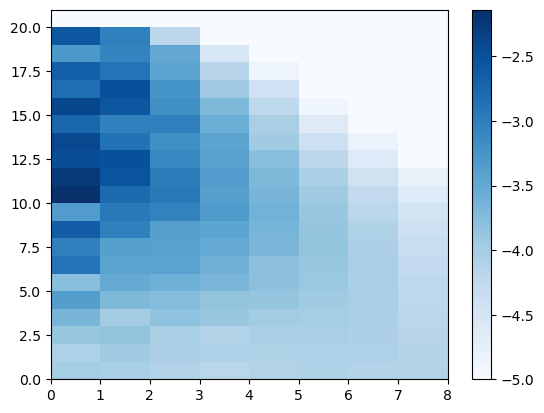

In [34]:
plt.pcolormesh(np.log10(np.array(coh_map8)+1e-10),vmin=-5,cmap='Blues')
plt.colorbar()

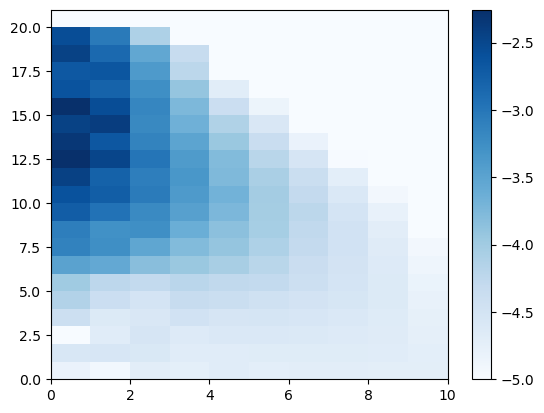

In [33]:
plt.pcolormesh(np.log10(np.array(coh_map10)+1e-10),vmin=-5,cmap='Blues')
plt.colorbar()

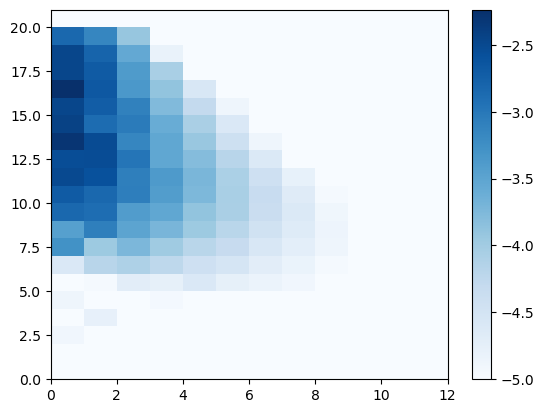

In [32]:
plt.pcolormesh(np.log10(np.array(coh_map12)+1e-10),vmin=-5,cmap='Blues')
plt.colorbar()

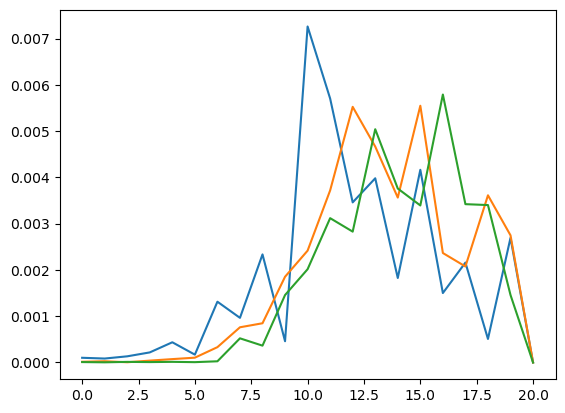

In [30]:
plt.plot(np.array(coh_map8)[:,0])
plt.plot(np.array(coh_map10)[:,0])
plt.plot(np.array(coh_map12)[:,0])

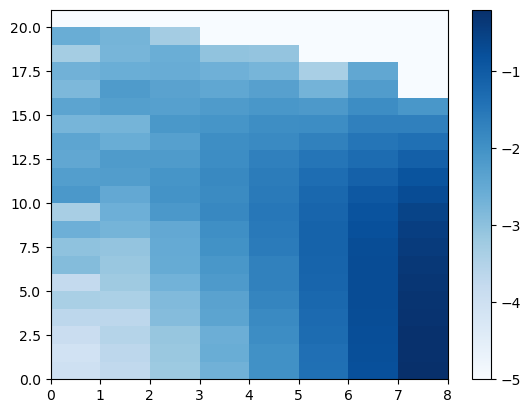

In [38]:
plt.pcolormesh(np.log10(np.array(coh_map8_raw)+1e-10),vmin=-5,cmap='Blues')
plt.colorbar()